<a href="https://colab.research.google.com/github/agpo-ilr-uni-bonn/PromotionskollegModule6800_2024/blob/master/6800_Day4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 4-5: Code used during lecture and lab assignment


## Instructions

- The notebook combines 'code used during lecture' with the corresponding lab assignment (see further down)
- Please add answers/discussion/comments to the notebook as comments or text box. Do not create another file in addition.
- When you are done with your assignment, save the notebook in drive and add your last name to the name of the file.
- To hand in the final notebook follow the instructions provided by email



# Code used during lecture: Causal Forest synthetic data

__General idea of this section:__
In this section we create synthetic data where we have a continous treatment and treatment effect are heterogenous. Treatment hererogeneity depends on only one variable, but we give the model multiple variables to check if it can identify which variables impacts treatment heterogeneity. Additionally, we check if the model can estimate the heterogeneity correctly.  


The example is based on: https://github.com/py-why/EconML/blob/main/notebooks/Causal%20Forest%20and%20Orthogonal%20Random%20Forest%20Examples.ipynb



In [45]:
# Install the econml package.
# See documentation https://econml.azurewebsites.net/index.html
!pip install -q econml

In [46]:
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso
import shap

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import matplotlib.pyplot as plt

%matplotlib inline


We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& W \beta + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + W \gamma + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP,
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [47]:
# Treatment effect function
# Note this function is used to define the treatment effect hetorogeneity,
# if you pass a matrix x only the only the first column of the matrix
# influences treatment heterogeneity
def exp_te(x):
    # Only first column in X actually affects treatment heterogeneity
    return np.exp(2*x[0])

# Set a random seed for reproducability
np.random.seed(123)
# Number of observations
n = 1000
# Number of potential covariates in W
n_w = 30
# Number of covariates that actually impact Y
support_size = 5
# Number of covariates to consider for treatment heterogeneity
n_x = 3

# Select randomly which variables i.e. columns of W actually impact Y
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
# Generate coefficients gamma
coefs_Y = np.random.uniform(0, 1, size=support_size)

# Treatment support, select which variables out of the support from Y
# that impacts T)
support_T = support_Y
# Generate coefficients beta
coefs_T = np.random.uniform(0, 1, size=support_size)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))

# Sample random uniform errors
epsilon = np.random.uniform(-1, 1, size=n)
eta = np.random.uniform(-1, 1, size=n)

# Derive heterogeneous treatment effects using function exp_te(x)
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
T = W[:, support_T] @ coefs_T + eta
# Define outcome Y
Y = TE * T + W[:, support_Y] @ coefs_Y + epsilon


In [48]:
# Define the model
estSyn = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       n_estimators=4000, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
# Tune the model
estSyn.tune(Y, T, X=X, W=W)
# Fit the model
estSyn.fit(Y, T, X=X, W=W)


In [50]:
# Check performance of second stage model (model of T)
estSyn.models_t[0][0].score(np.concatenate([X,W],axis=1),T)

0.839253169448463

In [49]:
# Check performance of second stage model (model of Y)
estSyn.models_y[0][0].score(np.concatenate([X,W],axis=1),Y)

0.7685646184503052

In [ ]:
# Define test data, for plots below
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

In [ ]:
treatment_effects = estSyn.effect(X_test)
# Calculate default (95%) confidence intervals for the test data
te_lower, te_upper = estSyn.effect_interval(X_test, alpha=0.01)

In [ ]:
res = estSyn.effect_inference(X_test)

In [ ]:
# Have a look at all the estimated treatment effects
res.summary_frame().head()


In [ ]:
# Calculate mean treatment effect estimates for X_test
print(res.summary_frame()['point_estimate'].mean())
print(np.mean(treatment_effects))

In [ ]:
# mean_point is the mean treatment effect estimate
res.population_summary()

In [ ]:
# Plot the estimated treatment heterogeneity with respect to X[:,0]
Xi = 0
plt.subplot()
plt.title("CausalForest")
plt.plot(X_test[:, Xi], treatment_effects, label='mean')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, Xi], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, Xi], te_lower, te_upper, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel(f"x{Xi}")
plt.legend()
plt.show()

In [ ]:
print('Feature Importance for treatment heterogeneity')
pd.DataFrame(estSyn.feature_importances_,index=[f'x{i}' for i in range(0,n_x)],
             columns=['feature_importances']
             ).sort_values('feature_importances',ascending=False)

In [ ]:
# Get shap values
shap_values = estSyn.shap_values(X)

In [ ]:
shap.plots.beeswarm(shap_values['Y0']['T0'])

# Lab 4a: Counterfactual prediction

The objective of the second part of today's lab is to determine the effects of protected areas on forest cover. To do this, we take the following strategy:

1) We estimate a model predicting forest cover where we use all of the observations that are not in a protected area.

2) We use this model to predict forest cover for observations with protected areas observations. This gives as a prediction about the expected forest cover given the characteristics of the cell (such as slope, elevation).

3) Using the predictions from 2) we compare the predicted forest cover with the actual forest cover. The difference between the two is the estimated effect of forest protected areas.

=> Most of the steps for the estimation should be familiar from previous labs.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# import seaborn for visualization
import seaborn as sns

In [2]:
# run this cell only once if you don't have wget installed
# its assumed you are using windows and have python installed
# only needed if you are running the notebook locally
# %pip install wget
#if not os.path.isfile('brazil_all_data_v2.gz'):
#    !python -m wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz
# Download data only once and make sure it is in the same folder as the notebook

# check if brazil_all_data_v2.gz is available in the current folder and if not, download it

if not os.path.isfile('brazil_all_data_v2.gz'):
    !wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz


NameError: name 'os' is not defined

In [ ]:
# load data into dataframe
df = pd.read_parquet('brazil_all_data_v2.gz')

In [ ]:
# Define target (dependent) variable (% forest cover for 2018)
strY = 'perc_treecover'

# Define a list of features names (explantory variables)
lstX = [
  # 'wdpa_2017', => Exclude protected areas
  'population_2015',
  'chirps_2017',
  'maize',
  'soy',
  'sugarcane',
  'perm_water',
  'travel_min',
  'cropland',
  'mean_elev',
  'sd_elev',
  'near_road',
  # 'wdpa_2017_lag_1st_order',
  'chirps_2017_lag_1st_order',
  'population_2015_lag_1st_order',
  'maize_lag_1st_order',
  'soy_lag_1st_order',
  'sugarcane_lag_1st_order',
  'perc_treecover_lag_1st_order',
  'perm_water_lag_1st_order',
  'travel_min_lag_1st_order',
  'cropland_lag_1st_order',
  'mean_elev_lag_1st_order',
  'sd_elev_lag_1st_order',
  'near_road_lag_1st_order',
 ]

In [ ]:
# Split that sample in those observations that ...
#... are protected areas
df_PA = df.loc[~(df['wdpa_2017']==0),:]

#... are NOT protected areas
df_NoPA = df.loc[df['wdpa_2017']==0,:]

print('Number of observations without protected area', df_NoPA.shape[0])
print('Number of observations with protected area', df_PA.shape[0])

In [ ]:
# Select the target variable
# ... for the observations without protected areas
Y_all_NoPA = df_NoPA[strY]
# ... for the observations with protected areas
Y_PA = df_PA[strY]

# Get the features
# ... for the observations without protected areas
X_all_NoPA =  df_NoPA.loc[:,lstX]
# ... for the observations wit protected areas
X_PA_raw =  df_PA.loc[:,lstX]

Choose a ML model and features to predict deforestation

In [ ]:
# Split the data into train and test using only the the observations
# without protected areas
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X_all_NoPA, Y_all_NoPA, test_size = 0.2)

In [ ]:

# Scale data to 0-1 range using sklearn MinMaxScalar object
# (see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
scaler = MinMaxScaler()
# Use only the train data to fit the MinMaxScalar
scaler.fit(X_train_raw)

# Apply the MinMax transformation to the train and test data
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


In [3]:
# Define a function to print model stats
def printModStats(mod,X_train, Y_train,X_test, Y_test, showPlot=True):
  # Inspect the model performancefor those observations that are
  # not protected areas
  print('Score in train', mod.score(X_train, Y_train))
  print('Score in test', mod.score(X_test, Y_test))

  # Get predicted values for the test set
  Y_test_had_Tree = mod.predict(X_test)

  # Calculate MSE in test set
  mse_ols_sklearn  = mean_squared_error(Y_test,Y_test_had_Tree)
  print('\nMean squared error: ',mse_ols_sklearn)
  # The coefficient of determination: 1 is perfect prediction
  R2_ols_sklearn = r2_score(Y_test,Y_test_had_Tree)
  print('Coefficient of determination: ',R2_ols_sklearn)

  if showPlot:
    # plot Y vs Y-hat
    h = sns.jointplot(Y_test_had_Tree, Y_test, kind="hex")
    h.set_axis_labels('Y predicted', 'Y true');



In [4]:
# Run XGBoost. In contrast to day 2 we now use XGBRegressor as our task is
# a regression task and not a classification task
import xgboost as xgb
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
model_xgb.fit(X_train, Y_train)


NameError: name 'X_train' is not defined

In [ ]:
printModStats(model_xgb,X_train, Y_train,X_test, Y_test, showPlot=True)

Now we use the trained model to make predictions for those areas with protected areas

In [ ]:
# First we need to scale the data for those observations without
# protected areas
X_PA = scaler.transform(X_PA_raw)

In [ ]:
# Lets define a function for our conterfactual that can be reused below
def calculateConterfactual(mod,X_PA):
  # Then use the train model to make predictions for protected areas
  Y_PA_had = mod.predict(X_PA)

  # Now we can compare the mean forest cover in protected area that we observer
  print(f'Predicted mean forest cover in protected Areas {np.mean(Y_PA_had):0.2f} %' )
  print(f'Actual mean forest cover in protected Areas {np.mean(Y_PA):0.2f} %', )
  print(f'Mean difference between predicted and observed forest cover: {np.mean(Y_PA-Y_PA_had):0.2f} pp')


In [ ]:
# Call function for our xgb model
calculateConterfactual(model_xgb,X_PA)

In [ ]:
# ================================
#  Task
# ================================

# Until now we have always used the default hyperparameters for XGBoost
# Lets see if we can improve model performance by optimizing some of those.
# Usually this is a rather complex and time consuming task with many
# different ways to approach this. Here we only try to optimize two paramters
# manually. Specifically we want to optimize "max_depth" (Typical values: 3-10)
# and "min_child_weight" (Typical values: 1-5).

# Hint: The caculation is quite time consuming. Coordinate in your team
#       to try as many combination as possible.

# In case you are interested you can find a complete guide for doing
# hyperparameter optimization for XGB here:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# This is NOT required for this task here, just to give you an idea of how
# many paramter can be optimized (Note, this referes to an older sklearn version,
# therefore some of the code might need to be adjusted)

# Specify model with "max_depth" and "min_child_weight" set explicitly
model_xgb_opt = ...

# Fit model to train data
model_xgb_opt....

# Print stats
printModStats(model_xgb_opt,X_train, Y_train,X_test, Y_test, showPlot=True)

# Do conterfactual
calculateConterfactual(model_xgb_opt,X_PA)

In [ ]:
# ================================
#  Optional Task
# ================================

# Try alternative ML models and check how they perform compared to XGBoost.
# If you are using sklearn you often only have to replace one line in oder to
# change your model. LightGBM for example is an alterantive to XGBoost that
# gained popularity.
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor.

## Alternative approach

- Train a model with "protected areas" included
- Select only the protected areas (in the test set)
- make a prediction for those areas for forest cover
- make a prediction for those areas for forest cover where we set the explanatory variable for "protected areas" equal to zero i.e. we make a prediction for forest cover under the assumption that those areas where not protected

In [ ]:
# Define binary variable for deforestration in 2018

Y_all = df['perc_treecover']
# Define a list of features names (explantory variables)
lstX = [
   'wdpa_2017',
  'population_2015',
  'chirps_2017',
  'maize',
  'soy',
  'sugarcane',
  'perm_water',
  'travel_min',
  'cropland',
  'mean_elev',
  'sd_elev',
  'near_road',
  'wdpa_2017_lag_1st_order',
  'chirps_2017_lag_1st_order',
  'population_2015_lag_1st_order',
  'maize_lag_1st_order',
  'soy_lag_1st_order',
  'sugarcane_lag_1st_order',
  'perc_treecover_lag_1st_order',
  'perm_water_lag_1st_order',
  'travel_min_lag_1st_order',
  'cropland_lag_1st_order',
  'mean_elev_lag_1st_order',
  'sd_elev_lag_1st_order',
  'near_road_lag_1st_order',
 ]

# Get the explanatory Variables
X_all =  df.loc[:,lstX]

In [ ]:


# Split the data into train and test using all observations

# Use only the train data to fit the MinMaxScalar


# Apply the MinMax transformation to the train and test data


In [ ]:
# train...


In [ ]:
# Get only those observations which are protected areas


In [ ]:
# do prediction for these as if they were not protected areas


In [ ]:
# And compare with the case they are protected



In [ ]:

# Now we can compare the mean forest cover in protected area that we observer



In [ ]:
# => Discuss pro and cons of the two approaches

# Lab b: Causal Forest for deforestration example

Task: The code below illustrate how CausalForest could be used for the deforestration example (in a very simplified way).
Before you run the code below hypothesis how

1) soy

2) mean_elev

3) near_road

might effect treatment heterogeneity. Write down the your hypothesis in the notebook below. Note, that there is on one single right answer to this, the idea is that you think about the expected effect before actually running the model.
  

In [ ]:
#####################
### Your Task #######
#####################
# Your hypothesis for "soy"
"""
Your answer here:
"""

In [ ]:
#####################
### Your Task #######
#####################
# Your hypothesis for "mean_elev"
"""
Your answer here:
"""

In [ ]:
#####################
### Your Task #######
#####################
# Your hypothesis for "near_road"
"""
Your answer here:
"""

### Now run the code below

In [2]:
# Install the econml package (if not already done above).
# See documentation https://econml.azurewebsites.net/index.html
!pip install -q econml

In [3]:
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso
import shap
import xgboost as xgb

# Helper imports
import os
import pandas as pd
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# run this cell only once if you don't have wget installed
# its assumed you are using windows and have python installed
# only needed if you are running the notebook locally
# %pip install wget
#if not os.path.isfile('brazil_all_data_v2.gz'):
#    !python -m wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz
# Download data only once and make sure it is in the same folder as the notebook

# check if brazil_all_data_v2.gz is available in the current folder and if not, download it

if not os.path.isfile('brazil_all_data_v2.gz'):
    !wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz

In [5]:
# Load data with pandas into a dataframe
df = pd.read_parquet('brazil_all_data_v2.gz')

In [6]:
# Define binary variable for deforestration in 2018
Y_all = df['defor_2018']

In [7]:
# Define a list of features names (explantory variables)

# This are the variables you include to derive treatment heterogeneity
lstX = [
  'soy',
  'mean_elev',
  'near_road',
 ]
# This are the variables you include as controll variables
lstW = [
  # 'wdpa_2017',
  'population_2015',
  'chirps_2017',
  'defor_2017',
  'maize',
  # 'soy',
  'sugarcane',
  'perc_treecover',
  'perm_water',
  'travel_min',
  'cropland',
  # 'mean_elev',
  'sd_elev',
  # 'near_road',
  'defor_2017_lag_1st_order',
  # 'wdpa_2017_lag_1st_order',
  'chirps_2017_lag_1st_order',
  'population_2015_lag_1st_order',
  'maize_lag_1st_order',
  'soy_lag_1st_order',
  'sugarcane_lag_1st_order',
  'perc_treecover_lag_1st_order',
  'perm_water_lag_1st_order',
  'travel_min_lag_1st_order',
  'cropland_lag_1st_order',
  'mean_elev_lag_1st_order',
  'sd_elev_lag_1st_order',
  'near_road_lag_1st_order',
 ]

# Make sure that variables in lstX are not in lstW
lstW = list(set(lstW)-set(lstX))

X_all =  df.loc[:,lstX]
W_all =  df.loc[:,lstW]
T_all = df['wdpa_2017']


In [8]:
# Split the data into train and test data using sklearn train_test_split object
#   (see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

# Note: This randomly split the data in 80% train and 20% test data
X_train_raw, X_test_raw,W_train_raw, W_test_raw, T_train, T_test, Y_train, Y_test = train_test_split(X_all,W_all,T_all, Y_all, test_size = 0.2)

In [9]:
# Scale data to 0-1 range using sklearn MinMaxScalar object
# (see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
scalerX = MinMaxScaler()
scalerW = MinMaxScaler()
# Use only the train data to fit the MinMaxScalar
scalerX.fit(X_train_raw)
scalerW.fit(W_train_raw)

# Apply the MinMax transformation to the train and test data
X_train = scalerX.transform(X_train_raw)
X_test = scalerX.transform(X_test_raw)
W_train = scalerW.transform(W_train_raw)
W_test = scalerW.transform(W_test_raw)
# Note the depended variable does not need to be scaled as it is a binary variable anyway
# Similarly, the treatment variables is between 0-1 and hence does not need to be scaled


In [ ]:
# Now train a CausalForest mode, actually what are using here
# is a combination of a CausalForest and "Double Machine Learning".
# Double machine Learning allows to control for non-linear effect of W on
# T and Y (by stripping out those effect) and then only estimate treatment
# heterogeneity with respect to X

# Note1: We substaintially reduce the number of estimators and the max_depth
#        to reduce runtime. For an actual application you might want to
#        consider higher values
est1 = CausalForestDML(
                       model_y=xgb.XGBRegressor(),
                       model_t=xgb.XGBRegressor(),
                       #  n_estimators=4000, min_samples_leaf=5,
                       #  max_depth=50,
                       n_estimators=100, min_samples_leaf=5,
                       max_depth=5,
                       verbose=0, random_state=123)
# Tune the model (see documentation:
# https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html#econml.dml.CausalForestDML.tune)
# Note2: We also restrict the size of the training data in the next tuning step
#        to reduce runtime. In an actual application you might not want to
#        do this.
# est1.tune(Y_train, T_train, X=X_train, W=W_train)
est1.tune(Y_train[:20000], T_train[:20000], X=X_train[:20000], W=W_train[:20000])

In [19]:
# Fit the model
est1.fit(Y_train, T_train, X=X_train, W=W_train)

In [20]:
# Note: model_y and model_t are estimated multiple times using cross-validation
#       est1.model_t containes a nested list of all the fitted models
#       (default value for cross-validation is 2, hence there are two fitted
#       instances in the list)
print('Score test set model t (instance 0)',est1.models_t[0][0].score(np.concatenate([X_test,W_test],axis=1),T_test))
print('Score test set model t (instance 1)',est1.models_t[0][1].score(np.concatenate([X_test,W_test],axis=1),T_test))
print('Score test set model y (instance 0)',est1.models_y[0][0].score(np.concatenate([X_test,W_test],axis=1),Y_test))
print('Score test set model y (instance 1)',est1.models_y[0][1].score(np.concatenate([X_test,W_test],axis=1),Y_test))

Score test set model t (instance 0) 0.8663804953318102
Score test set model t (instance 1) 0.8666780303441932
Score test set model y (instance 0) 0.12201595422750589
Score test set model y (instance 1) 0.15881159052082328


In [ ]:
#####################
### Your Task #######
#####################
# What are these two numbers telling you
"""
Your answer here:
"""

In [21]:
print('Feature Importance for treatment heterogeneity')
pd.DataFrame(est1.feature_importances_,index=lstX,columns=['feature_importances']).sort_values('feature_importances',ascending=False)

Feature Importance for treatment heterogeneity


,feature_importances
near_road,0.433229
soy,0.289918
mean_elev,0.276853


In [ ]:
#####################
### Your Task #######
#####################
# How do you interpret the above table. Explain in you own words.
"""
Your answer here:
"""

In [23]:
# Calculate SHAP values for the first 1000 test samples
shap_values = est1.shap_values(X_test[:10000],feature_names=lstX)


 99%|===================| 9910/10000 [00:39<00:00]       

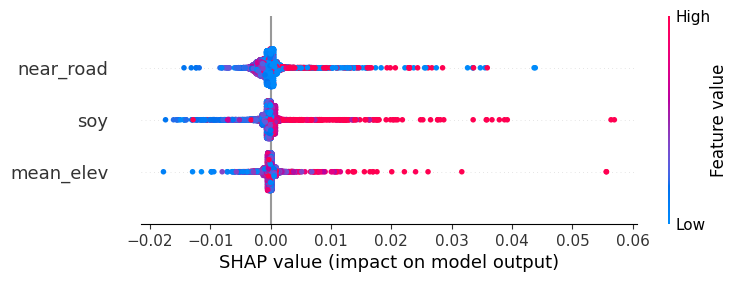

In [25]:
# Plot SHAP values (for treatment heterogeneity)
shap.plots.beeswarm(shap_values['defor_2018']['wdpa_2017'])

In [ ]:
#####################
### Your Task #######
#####################
# How do you interpret the plot above. Relate this to the hypothesis you
# defined above
"""
Your answer here:
"""

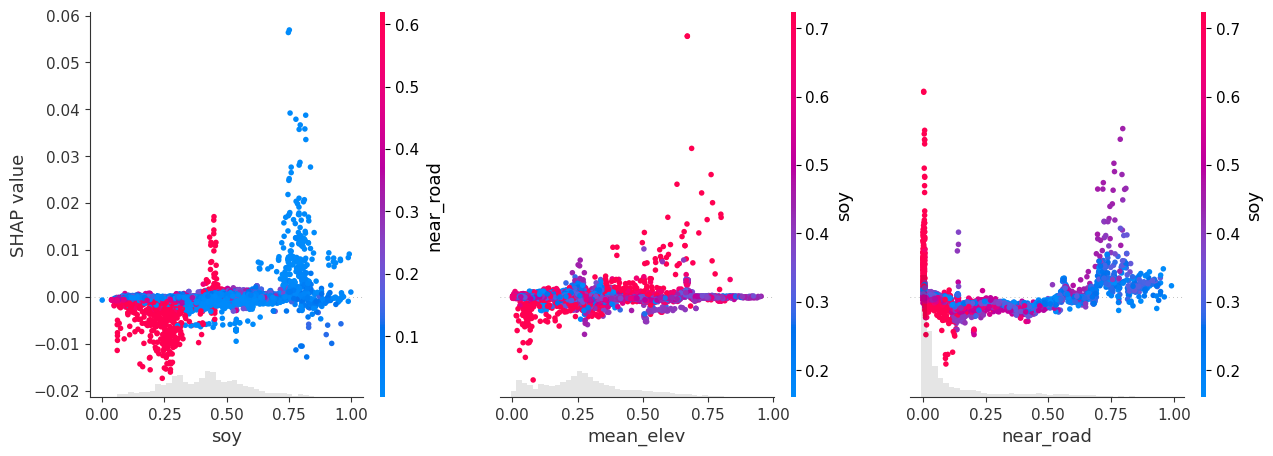

In [30]:
# TODO think about if this is actually useful
shap.plots.scatter(shap_values['defor_2018']['wdpa_2017'], color=shap_values['defor_2018']['wdpa_2017'])

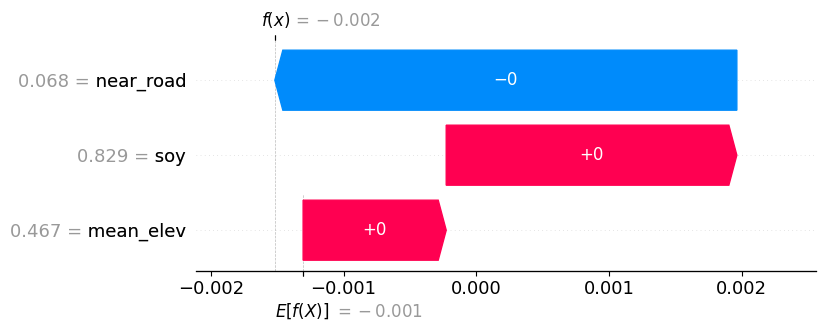

In [27]:
# TODO think about if this is actually useful
sample_ind = 0
shap.plots.waterfall(shap_values['defor_2018']['wdpa_2017'][sample_ind])